In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt; plt.rc('font', size=12)
import matplotlib.cm as cm
import seaborn as sns
from scipy.spatial import procrustes
from scipy.stats import percentileofscore
from mlxtend.evaluate import permutation_test
import re
from collections import Counter

In [2]:
taxa = ['B_caccae',
        'B_cellulosilyticus_WH2',
        'B_ovatus',
        'B_thetaiotaomicron',
        'B_uniformis',
        'B_vulgatus',
        'C_aerofaciens',
        'C_scindens',
        'C_spiroforme',
        # 'D_longicatena',
        'P_distasonis',
        'R_obeum'
        ]

pretty_names_dir = {'B_caccae': '$B. caccae$',
                'B_cellulosilyticus_WH2': '$B. cellulosilyticus$',
                'B_ovatus': '$B. ovatus$',
                'B_thetaiotaomicron': '$B. thetaiotaomicron$',
                'B_uniformis': '$B. uniformis$',
                'B_vulgatus': '$B. vulgatus$',
                'C_aerofaciens': '$C. aerofaciens$',
                'C_scindens': '$C. scindens$',
                'C_spiroforme': '$C. spiroforme$',
                # 'D_longicatena': '$D. longicatena$',
                'P_distasonis': '$P. distasonis$',
                'R_obeum': '$R. obeum$'
                }

abbr_names_dir = {'B_caccae': 'Bca',
                'B_cellulosilyticus_WH2': 'Bce',
                'B_ovatus': 'Bov',
                'B_thetaiotaomicron': 'Bth',
                'B_uniformis': 'Bun',
                'B_vulgatus': 'Bvu',
                'C_aerofaciens': 'Cae',
                'C_scindens': 'Csc',
                'C_spiroforme': 'Csp',
                # 'D_longicatena': 'Dlo',
                'P_distasonis': 'Pdi',
                'R_obeum': 'Rob'
                }

pretty_names = [pretty_names_dir[taxa] for taxa in taxa]
pretty_names
abbr_names = [abbr_names_dir[taxa] for taxa in taxa]
abbr_names

['Bca', 'Bce', 'Bov', 'Bth', 'Bun', 'Bvu', 'Cae', 'Csc', 'Csp', 'Pdi', 'Rob']

In [3]:
input_path_lf0 = Path(f'mcnulty-results/best-chains/mcnulty-LF0-seed53/inference/posteriors/interactions_matrices')
input_path_hf0 = Path(f'mcnulty-results/best-chains/mcnulty-HF0-seed3/inference/posteriors/interactions_matrices')

In [4]:
inter_bayes_lf0 = pd.read_table(f'{input_path_lf0}/bayes_factors_matrix.tsv', index_col=0)
interactions_lf0 = pd.read_table(f'{input_path_lf0}/median_matrix.tsv', index_col=0)
inter_bayes_hf0 = pd.read_table(f'{input_path_hf0}/bayes_factors_matrix.tsv', index_col=0)
interactions_hf0 = pd.read_table(f'{input_path_hf0}/median_matrix.tsv', index_col=0)

In [5]:
def mask_by_bayes(interactions, inter_bayes):
    inter_bayes = inter_bayes.copy()
    interactions = interactions.copy()

    inter_bayes_mask = inter_bayes > np.sqrt(10)
    inter_bayes_mask = inter_bayes_mask.values
    
    interactions_matrix = interactions.values
    interactions_masked = np.ma.masked_array(interactions_matrix, mask=~inter_bayes_mask)
    interactions_masked = interactions_masked.filled(np.nan)
    return interactions_masked

def get_smallest_order_of_magnitude(x):
    return int(np.floor(np.log10(np.nanmin(np.abs(x)))))

# def max_min_swap(x):
#     x = x.copy()
#     x_min = np.nanmin(x)
#     x_max = np.nanmax(x)
#     for i in range(x.shape[0]):
#         for j in range(x.shape[1]):
#             if np.isnan(x[i,j]):
#                 continue
#             x[i,j] = x_max + x_min - x[i,j]
#     return x

# def tranform_interaction_matrix(interactions, inter_bayes):
#     interactions_masked = mask_by_bayes(interactions, inter_bayes)
#     transformed_interaction_matrix = max_min_swap(np.absolute(np.log10(np.absolute(interactions_masked)))) * np.sign(interactions_masked)
#     return transformed_interaction_matrix

def tranform_interaction_matrix(interactions, inter_bayes):
    interactions_masked = mask_by_bayes(interactions, inter_bayes)
    smallest_order_of_magnitude = get_smallest_order_of_magnitude(interactions_masked)
    transformed_interaction_matrix = np.log10(np.abs(interactions_masked * 10**(-1*smallest_order_of_magnitude))) * np.sign(interactions_masked)
    return transformed_interaction_matrix

# def min_max_norm(x):
#     x = x.values.copy()
#     x_max = np.nanmax(x)
#     x_min = np.nanmin(x)
#     for i in range(x.shape[0]):
#         for j in range(x.shape[1]):
#             if np.isnan(x[i,j]):
#                 continue
#             x[i,j] = (x[i,j] - x_min) / (x_max - x_min)
#     return x

In [6]:
masked_lf0 = pd.DataFrame(mask_by_bayes(interactions_lf0, inter_bayes_lf0),
                          index=pretty_names, 
                          columns=pretty_names)
masked_hf0 = pd.DataFrame(mask_by_bayes(interactions_hf0, inter_bayes_hf0), 
                            index=pretty_names,
                            columns=pretty_names)

In [7]:
print(np.nanmin(np.abs(masked_lf0)))
print(np.nanmax(np.abs(masked_lf0)))

1.0573290484610336e-09
2.044223738858441e-07


In [8]:
print(np.nanmin(np.abs(masked_hf0)))
print(np.nanmax(np.abs(masked_hf0)))

2.13049086558384e-09
1.2454877778773537e-07


In [9]:
ints = []
for i in range(masked_lf0.shape[0]):
    for j in range(masked_lf0.shape[1]):
        if i != j:
            if (masked_lf0.iloc[i,j] > 0) and (masked_lf0.iloc[j,i] > 0):
                ints.append('pp')
            elif (masked_lf0.iloc[i,j] < 0) and (masked_lf0.iloc[j,i] < 0):
                ints.append('nn')
            elif (masked_lf0.iloc[i,j] > 0) and (masked_lf0.iloc[j,i] < 0):
                ints.append('pn')
            elif (masked_lf0.iloc[i,j] < 0) and (masked_lf0.iloc[j,i] > 0):
                ints.append('pn')
            elif (masked_lf0.iloc[i,j] > 0) and (np.isnan(masked_lf0.iloc[j,i])):
                ints.append('p0')
            elif (masked_lf0.iloc[i,j] < 0) and (np.isnan(masked_lf0.iloc[j,i])):
                ints.append('n0')
            elif (np.isnan(masked_lf0.iloc[i,j])) and (masked_lf0.iloc[j,i] > 0):
                ints.append('p0')
            elif (np.isnan(masked_lf0.iloc[i,j])) and (masked_lf0.iloc[j,i] < 0):
                ints.append('n0')
            elif (np.isnan(masked_lf0.iloc[i,j])) and (np.isnan(masked_lf0.iloc[j,i])):
                ints.append('00')
tot = sum(Counter(ints).values())
for key,values in Counter(ints).items():
    print(f'{key}: {(values/tot)*100} %')

00: 7.2727272727272725 %
pn: 9.090909090909092 %
n0: 21.818181818181817 %
nn: 47.27272727272727 %
p0: 10.909090909090908 %
pp: 3.6363636363636362 %


In [10]:
ints = []
for i in range(masked_hf0.shape[0]):
    for j in range(masked_hf0.shape[1]):
        if i != j:
            if (masked_hf0.iloc[i,j] > 0) and (masked_hf0.iloc[j,i] > 0):
                ints.append('pp')
            elif (masked_hf0.iloc[i,j] < 0) and (masked_hf0.iloc[j,i] < 0):
                ints.append('nn')
            elif (masked_hf0.iloc[i,j] > 0) and (masked_hf0.iloc[j,i] < 0):
                ints.append('pn')
            elif (masked_hf0.iloc[i,j] < 0) and (masked_hf0.iloc[j,i] > 0):
                ints.append('pn')
            elif (masked_hf0.iloc[i,j] > 0) and (np.isnan(masked_hf0.iloc[j,i])):
                ints.append('p0')
            elif (masked_hf0.iloc[i,j] < 0) and (np.isnan(masked_hf0.iloc[j,i])):
                ints.append('n0')
            elif (np.isnan(masked_hf0.iloc[i,j])) and (masked_hf0.iloc[j,i] > 0):
                ints.append('p0')
            elif (np.isnan(masked_hf0.iloc[i,j])) and (masked_hf0.iloc[j,i] < 0):
                ints.append('n0')
            elif (np.isnan(masked_hf0.iloc[i,j])) and (np.isnan(masked_hf0.iloc[j,i])):
                ints.append('00')
tot = sum(Counter(ints).values())
for key,values in Counter(ints).items():
    print(f'{key}: {(values/tot)*100} %')

n0: 14.545454545454545 %
00: 61.81818181818181 %
p0: 21.818181818181817 %
pn: 1.8181818181818181 %


In [11]:
ints = []
for i in range(masked_lf0.shape[0]):
    for j in range(masked_hf0.shape[1]):
        if i != j:
            if (np.isnan(masked_lf0.iloc[i,j])) & (np.isnan(masked_hf0.iloc[i,j])):
                ints.append('cons')
            elif np.isnan(masked_lf0.iloc[i,j]):
                ints.append('0_lf0')
            elif np.isnan(masked_hf0.iloc[i,j]):
                ints.append('0_hf0')
            elif np.sign(masked_lf0.iloc[i,j]) == np.sign(masked_hf0.iloc[i,j]):
                ints.append('cons')
            else:
                ints.append('anti')
tot = sum(Counter(ints).values())
for key,values in Counter(ints).items():
    print(f'{key}: {(values/tot)*100} %')

cons: 25.454545454545453 %
0_hf0: 60.0 %
0_lf0: 3.6363636363636362 %
anti: 10.909090909090908 %


In [12]:
transformed_interaction_matrix_lf0 = pd.DataFrame(tranform_interaction_matrix(interactions_lf0, inter_bayes_lf0), 
                                                  index=abbr_names, 
                                                  columns=abbr_names)

transformed_interaction_matrix_hf0 = pd.DataFrame(tranform_interaction_matrix(interactions_hf0, inter_bayes_hf0), 
                                                  index=abbr_names, 
                                                  columns=abbr_names)

In [13]:
difference = np.absolute(np.log10(np.absolute(masked_lf0)) - np.log10(np.absolute(masked_hf0))) * np.sign(masked_lf0) * np.sign(masked_hf0)
mask = np.isnan(difference)

In [14]:
matrix1 = np.nan_to_num(transformed_interaction_matrix_lf0.values)
matrix2 = np.nan_to_num(transformed_interaction_matrix_hf0.values)

# matrix1 = np.nan_to_num(masked_lf0.values)
# matrix2 = np.nan_to_num(masked_hf0.values)

# Procrustes analysis
mtx1_trans, mtx2_trans, disparity = procrustes(matrix1, matrix2)

# Perform a permutation test

n_permutations = 10000
null_disparity = np.zeros(n_permutations)
for i in range(n_permutations):
    # Shuffle the rows of matrix2
    shuffled_matrix2 = np.random.permutation(matrix2)
    # shuffled_matrix2 = matrix2[np.random.permutation(matrix2.shape[0]), :]
    # Run Procrustes analysis on the shuffled matrix
    _, _, null_disparity[i] = procrustes(matrix1, shuffled_matrix2)

# Calculate p-value based on percentile of observed disparity value in null distribution
p_value_disp = percentileofscore(null_disparity, disparity) / 100

# Print the results
print(f"Disparity: {disparity:.4f}")
print(f"Disparity P-value: {p_value_disp:.4f}")

Disparity: 0.6112
Disparity P-value: 0.3236


In [15]:
permutation_test(matrix1.flatten(), matrix2.flatten(), method='approximate', num_rounds=10000, seed=0, paired=True)

9.999000099990002e-05

## Stability analysis

In [16]:
input_path = Path(f'mcnulty-results/best-chains/mcnulty-LF0-seed53/inference/posteriors')
nodes_lf0 = []
for param in ['growth', 'self_interaction', 'perturbation']:
    table = pd.read_table(input_path / f'{param}.tsv', index_col=0)
    table = table.add_prefix(f'{param}_')
    nodes_lf0.append(table)
nodes_lf0 = pd.concat(nodes_lf0, axis=1)

input_path = Path(f'mcnulty-results/best-chains/mcnulty-HF0-seed3/inference/posteriors')
nodes_hf0 = []
for param in ['growth', 'self_interaction', 'perturbation']:
    table = pd.read_table(input_path / f'{param}.tsv', index_col=0)
    table = table.add_prefix(f'{param}_')
    nodes_hf0.append(table)
nodes_hf0 = pd.concat(nodes_hf0, axis=1)

In [17]:
masked_lf0_ = masked_lf0.copy()
for i in range(len(nodes_lf0['self_interaction_median'])):
    masked_lf0_.iloc[i, i] = - nodes_lf0['self_interaction_median'].iloc[i]
    
masked_hf0_ = masked_hf0.copy()
for i in range(len(nodes_hf0['self_interaction_median'])):
    masked_hf0_.iloc[i, i] = - nodes_hf0['self_interaction_median'].iloc[i]

In [18]:
# np.sort(np.linalg.eig(np.nan_to_num(masked_.values))[0])
np.linalg.eig(np.nan_to_num(masked_lf0_.values))[0]

array([-1.31666914e-06+0.00000000e+00j, -3.25676273e-07+0.00000000e+00j,
       -8.07646838e-08+0.00000000e+00j, -4.85399722e-08+0.00000000e+00j,
       -3.22260272e-08+0.00000000e+00j, -1.57292199e-08+5.23092742e-09j,
       -1.57292199e-08-5.23092742e-09j, -1.17151353e-08+0.00000000e+00j,
       -4.82426711e-09+3.63316172e-10j, -4.82426711e-09-3.63316172e-10j,
       -1.54609143e-09+0.00000000e+00j])

In [19]:
# np.sort(np.linalg.eig(np.nan_to_num(masked_.values))[0])
np.linalg.eig(np.nan_to_num(masked_hf0_.values))[0]

array([-7.45603889e-09+0.00000000e+00j, -4.11767624e-09+0.00000000e+00j,
       -1.80347893e-07+0.00000000e+00j, -1.54575245e-08+1.01888175e-08j,
       -1.54575245e-08-1.01888175e-08j, -3.10214868e-08+0.00000000e+00j,
       -5.79470242e-08+0.00000000e+00j, -2.63124064e-09+0.00000000e+00j,
       -1.13449861e-08+0.00000000e+00j, -1.81114482e-08+0.00000000e+00j,
       -8.31757789e-07+0.00000000e+00j])

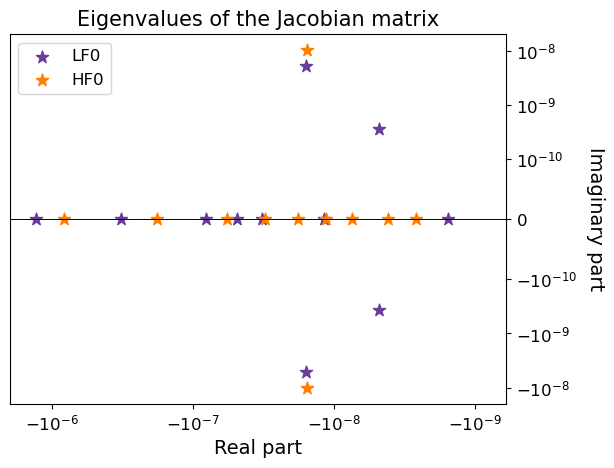

In [20]:
plt.scatter(np.real(np.linalg.eig(np.nan_to_num(masked_lf0_.values))[0]), 
    np.imag(np.linalg.eig(np.nan_to_num(masked_lf0_.values))[0]), 
    color=cm.Paired(9), 
    alpha=1, 
    marker='*',
    s=85,
    label='LF0')
plt.scatter(np.real(np.linalg.eig(np.nan_to_num(masked_hf0_.values))[0]), 
    np.imag(np.linalg.eig(np.nan_to_num(masked_hf0_.values))[0]), 
    color=cm.Paired(7), 
    alpha=1, 
    marker='*', 
    s=85,
    label='HF0')
plt.axhline(y=0, color='k', linewidth=0.7)
plt.xscale('symlog', linthresh=1e-9)
plt.yscale('symlog', linthresh=1e-10)
plt.xlim(-2e-6, -8e-10)
plt.ylim(-2e-8, 2e-8)
plt.xlabel('Real part', fontsize=14)
plt.ylabel('Imaginary part', fontsize=14, rotation=270, labelpad=20)
plt.xticks(fontsize=12)
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.legend(loc=2, fontsize=12)
plt.title('Eigenvalues of the Jacobian matrix', fontsize=15)
plt.savefig('mcnulty-results/stability.svg', bbox_inches='tight')
plt.show()